## Import Modules

In [44]:
import pandas as pd
import numpy as np

import torch
from ultralytics import settings
from ultralytics import YOLO

import os
import json

from pathlib import Path
import shutil
from tqdm.auto import tqdm
import yaml
from concurrent.futures import ThreadPoolExecutor, as_completed

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches






# Module Config

In [14]:
# Ultralytics settings
print(settings) 

# GPU Utilisation
print(torch.cuda.is_available())
device = torch.device("cuda")

{'settings_version': '0.0.4', 'datasets_dir': 'D:\\Tom\\GitHub\\Third Year Project\\datasets', 'weights_dir': 'D:\\Tom\\GitHub\\Third Year Project\\Intruder-Aircraft-Detection\\weights', 'runs_dir': 'D:\\Tom\\GitHub\\Third Year Project\\Intruder-Aircraft-Detection\\runs', 'uuid': 'fdb5c10788ffaa41a9047dc764dd8a0a3287d6bec12c0c66234ac745c0366efa', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}
True


## Load Dataset

In [15]:
# Base paths for the images and labels
train_images_path = 'datasets/AVOIDDS/images/train'
train_labels_path = 'datasets/AVOIDDS/labels/train'
val_images_path = 'datasets/AVOIDDS/images/valid'
val_labels_path = 'datasets/AVOIDDS/labels/valid'

# Load the metadata
metadata_path = 'datasets/AVOIDDS/metadata.json'
with open(metadata_path, 'r') as file:
    metadata = json.load(file)

# Function to create a DataFrame from images and labels
def create_dataframe(images_path, labels_path, metadata):

    # List all files in the directories
    image_files = [f for f in sorted(os.listdir(images_path)) if f.endswith('.jpg')]
    label_files = [f for f in sorted(os.listdir(labels_path)) if f.endswith('.txt')]
    
    # Create tempory DataFrame so that final dataframe is in correct order
    temp_df = pd.DataFrame({
        'image_path': [str(images_path + '/' + file) for file in image_files],
        'label_path': [str(labels_path + '/' + file) for file in label_files],
    })

    # Extract image indices to match with metadata
    df = pd.DataFrame()
    df['imageID'] = temp_df['image_path'].apply(lambda x: int(os.path.splitext(os.path.basename(x))[0]))

    # Add image and label paths to final dataframe
    df['image_path'] = temp_df['image_path']
    df['label_path'] = temp_df['label_path']
 
    # Add metadata to each image entry
    for key, value in metadata.items():
        if '.' in key:  # Key represents a range
            start, end = map(int, key.split('.'))
            df.loc[df['imageID'].between(start, end), 'metadata'] = json.dumps(value)

    # Convert the JSON strings in 'metadata' to dictionaries
    df['metadata'] = df['metadata'].apply(json.loads)

    # Expand the 'metadata' column into separate columns
    metadata_df = pd.json_normalize(df['metadata'])
    
    # Concatenate the expanded metadata back to the original DataFrame
    full_df = pd.concat([df.drop(['metadata'], axis=1), metadata_df], axis=1)

    return full_df

# Create the DataFrames for the train and validation sets
train_df = create_dataframe(train_images_path, train_labels_path, metadata)
valid_df = create_dataframe(val_images_path, val_labels_path, metadata)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64800 entries, 0 to 64799
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imageID      64800 non-null  int64  
 1   image_path   64800 non-null  object 
 2   label_path   64800 non-null  object 
 3   location     64800 non-null  object 
 4   enrange      64800 non-null  float64
 5   urange       64800 non-null  float64
 6   weather      64800 non-null  int64  
 7   daystart     64800 non-null  float64
 8   dayend       64800 non-null  float64
 9   num_train    64800 non-null  int64  
 10  num_valid    64800 non-null  int64  
 11  append       64800 non-null  bool   
 12  datasetname  64800 non-null  object 
 13  ac           64800 non-null  object 
 14  allweather   64800 non-null  bool   
 15  newac        64800 non-null  bool   
 16  own_h        64800 non-null  object 
 17  own_p_max    64800 non-null  float64
 18  own_r_max    64800 non-null  float64
 19  intr

# Create sub datasets

In [31]:
def create_dataset(dataset_name, filtered_train_df, filtered_valid_df, class_names=['aircraft'], dataset_dir="datasets/"):
    dataset_dir = Path(dataset_dir) / dataset_name
    images_dir = dataset_dir / 'images'
    labels_dir = dataset_dir / 'labels'

    # removes all files and folders from dataset directory
    def clear_directory(dir_path):    
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)

    # Clear directories if they exist, to overwrite the dataset
    for subdir in ['train', 'valid']:
        img_subdir = images_dir / subdir
        label_subdir = labels_dir / subdir
        if img_subdir.exists():
            clear_directory(img_subdir)
        else:
            img_subdir.mkdir(parents=True, exist_ok=True)
        if label_subdir.exists():
            clear_directory(label_subdir)
        else:
            label_subdir.mkdir(parents=True, exist_ok=True)

    # Create directories
    #for subdir in ['train', 'valid']:
    #    (images_dir / subdir).mkdir(parents=True, exist_ok=True)
    #    (labels_dir / subdir).mkdir(parents=True, exist_ok=True)

    def copy_file(src, dest):
        shutil.copy2(src, dest)

    def copy_files_concurrently(df, img_dest_dir, label_dest_dir):
        with ThreadPoolExecutor() as executor:
            # Prepare futures for image and label copying
            futures = [executor.submit(copy_file, row['image_path'], img_dest_dir / f"{Path(row['image_path']).name}") for _, row in df.iterrows()]
            futures += [executor.submit(copy_file, row['label_path'], label_dest_dir / f"{Path(row['label_path']).name}") for _, row in df.iterrows()]
            
            # Initialize progress bar
            pbar = tqdm(total=len(futures), desc='Copying files')
            for future in as_completed(futures):
                # Update progress bar upon task completion
                pbar.update(1)
            pbar.close()

    print("Copying training files:")
    copy_files_concurrently(filtered_train_df, images_dir / 'train', labels_dir / 'train')
    print("Copying validation files:")
    copy_files_concurrently(filtered_valid_df, images_dir / 'valid', labels_dir / 'valid')

    # Construct the YAML content with the desired structure
    yaml_content = {
        'path': str(f'../{dataset_dir}').replace('\\', '/'),  # Ensuring forward slashes
        'train': str('images/train').replace('\\', '/'),
        'val': str('images/valid').replace('\\', '/'),
        'names': {index: name for index, name in enumerate(class_names)}
    }  

    yaml_path = dataset_dir / f"{dataset_name}.yaml"
    with open(yaml_path, 'w') as file:
        yaml.dump(yaml_content, file, sort_keys=False)

    print(f"Dataset '{dataset_name}' created at {dataset_dir}")



In [35]:
test_train_df = train_df[train_df['image_path'] == 'datasets/AVOIDDS/images/train/16.jpg']
test_valid_df = valid_df[valid_df['image_path'] == 'datasets/AVOIDDS/images/valid/928.jpg']

dataset_name = 'test'

create_dataset(dataset_name, test_train_df, test_valid_df)

Copying training files:


Copying files:   0%|          | 0/2 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset 'test' created at datasets\test


# Augmentation Methods

In [48]:
# extracts class names and bboxes from all objects in label
def load_yolo_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
        bboxes = [list(map(float, label[1:])) for label in labels]
        class_labels = [int(label[0]) for label in labels]
    return bboxes, class_labels

# takes class names and augmented bbox and converts into yolo label format
def format_yolo_label(class_labels, augmented_bboxes):
    label_str = ""
    for class_label, bbox in zip(class_labels, augmented_bboxes):
        label_str += f"{class_label} " + " ".join(f"{x:.6f}" for x in bbox) + "\n"
    return label_str

In [42]:

## horizontal/vertical flip

def augment_flip(image_path, label_path, orientation, p=1.0):
    # Load image - openCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load labels
    bboxes, class_labels = load_yolo_labels(label_path)
    
    # Define the augmentation based on the orientation parameter
    if orientation == 'h':
        flip = A.HorizontalFlip(p=p)
    elif orientation == 'v':
        flip = A.VerticalFlip(p=p)
    else:
        raise ValueError("Orientation must be 'h' or 'v'")
    
    transform = A.Compose([
        flip,
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    # Apply transformation
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    augmented_image = transformed['image']
    augmented_bboxes = transformed['bboxes']
    
    # YOLO formatted label: [class_id, x_center, y_center, width, height]
    augmented_label = format_yolo_label(class_labels, augmented_bboxes)
    
    return augmented_image, augmented_label

In [80]:
## rotation

def augment_rotation(image_path, label_path, angle, p=1.0):
   
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load labels
    bboxes, class_labels = load_yolo_labels(label_path)
    
    # Define the augmentation with rotation
    transform = A.Compose([
        A.Rotate(limit=(angle, angle), p=p, border_mode=cv2.BORDER_CONSTANT),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    # Apply transformation
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    augmented_image = transformed['image']
    augmented_bboxes = transformed['bboxes']
    
    # Convert augmented bboxes and class labels back to YOLO format
    augmented_label = format_yolo_label(class_labels, augmented_bboxes)
    
    return augmented_image, augmented_label

In [21]:
## contrast and brightness

# Alpha - contrast control (1.0-3.0)
# Beta - brightness control (-100 to 100)
def augment_brightness_contrast(image_path, alpha=1.0, beta=0):
    
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply brightness and contrast adjustment
    augmented_image = np.clip(alpha * image.astype(np.float32) + beta, 0, 255).astype(np.uint8)
    
    return augmented_image

In [22]:
## histogram equalisation with CLAHE

def augment_histogram_equalization(image_path, p=1.0):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Define the augmentation
    transform = A.Compose([
        A.CLAHE(p),
    ])
    
    # Apply the augmentation
    transformed = transform(image=image)
    augmented_image = transformed['image']
    
    return augmented_image

In [23]:
## white balancing - gray word algorithm

def augmment_white_balance(image_path):
  
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate the mean of each channel
    mr = np.mean(image[:, :, 0])
    mg = np.mean(image[:, :, 1])
    mb = np.mean(image[:, :, 2])
    
    # Calculate the overall mean
    mgray = (mr + mg + mb) / 3
    
    # Scale the channels based on the Gray World assumption
    image[:, :, 0] = np.clip(image[:, :, 0] * (mgray / mr), 0, 255)
    image[:, :, 1] = np.clip(image[:, :, 1] * (mgray / mg), 0, 255)
    image[:, :, 2] = np.clip(image[:, :, 2] * (mgray / mb), 0, 255)
    
    augmented_image = image.astype(np.uint8)
    return augmented_image

In [114]:
## sharpening 

def augment_sharpen(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Kernels from literature research
    kernel_1 = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]], dtype=np.float32)
    
    kernel_2 = np.array([[-1, -2, -1],
                         [-2, 13, -2],
                         [-1, -2, -1]], dtype=np.float32)

    kernel_2 = np.array([[-1, -2, -1],
                         [-2, 16, -2],
                         [-1, -2, -1]], dtype=np.float32)
    
    # Apply the sharpening kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel_1)
    
    return sharpened_image

In [120]:
## guassian noise

def augment_gaussian_noise(image_path, var_limit=(10.0, 50.0)):
   
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Define the augmentation
    transform = A.Compose([
        A.GaussNoise(var_limit=var_limit, mean=0, p=1.0),
    ])
    
    # Apply the augmentation
    transformed = transform(image=image)
    augmented_image = transformed['image']
    
    return augmented_image

In [170]:
## zoom in 

def augment_zoom(image_path, label_path, zoom_factor=1.0):
    # If zoom_factor is 1, we expect no change to the image.
    #if zoom_factor == 1:
    #    return image, label  # Assuming these are already loaded before calling this function.
    
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    
    # Load labels
    bboxes, class_labels = load_yolo_labels(label_path)
    
    # Check that there are bounding boxes
    if not bboxes:
        raise ValueError("No bounding boxes provided.")

    # Calculate the new size and position of the bounding box after zoom
    new_bboxes = []
    for bbox in bboxes:
        x_center, y_center, bbox_width, bbox_height = bbox
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height
        
        # Apply the zoom factor
        new_width = bbox_width / zoom_factor
        new_height = bbox_height / zoom_factor 
        # Calculate the new bounding box position
        new_x_center = max(0, min(width, x_center))
        new_y_center = max(0, min(height, y_center))

        new_x_min = max(0, new_x_center - new_width / 2)
        new_y_min = max(0, new_y_center - new_height / 2)
        
        # Clip to image boundaries
        new_x_min = max(0, min(new_x_min, width - new_width))
        new_y_min = max(0, min(new_y_min, height - new_height))
        
        # Calculate new max values
        new_x_max = new_x_min + new_width
        new_y_max = new_y_min + new_height

        # Crop the image around the new bounding box
        crop = image[int(new_y_min):int(new_y_max), int(new_x_min):int(new_x_max)]
        
        # Resize cropped image back to original dimensions
        resized_crop = cv2.resize(crop, (width, height), interpolation=cv2.INTER_LINEAR)

        # Update bounding box coordinates for resized crop
        new_bboxes.append([
            (new_x_min + new_width / 2) / width, 
            (new_y_min + new_height / 2) / height, 
            new_width / width, 
            new_height / height
        ])
    
    # Convert bounding boxes back to YOLO format
    augmented_label = format_yolo_label(class_labels, new_bboxes)

    return resized_crop, augmented_label


In [68]:
## tester method to overlay bboxes on images

def overlay_bbox(image_path, label_path):

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load labels
    bboxes, class_labels = load_yolo_labels(label_path)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    height, width, _ = image.shape
    for bbox, class_label in zip(bboxes, class_labels):
        x_center, y_center, bbox_width, bbox_height = bbox
        x_min = (x_center - bbox_width / 2) * width
        y_min = (y_center - bbox_height / 2) * height
        
        rect = patches.Rectangle((x_min, y_min), bbox_width * width, bbox_height * height,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min - 2, str(class_label), color='red', fontsize=10, 
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='red', boxstyle='round'))
    
    plt.axis('off')
    plt.show()

In [59]:
#method to save image
def save_image(path, image):

    # Ensure the directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    

    # Convert from RGB to BGR
    image_to_save = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Save the image
    cv2.imwrite(path, image_to_save)

In [56]:
# ethod to save label
def save_label(path, contents):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Now, save the file
    with open(path, 'w') as label_file:
        label_file.write(contents)

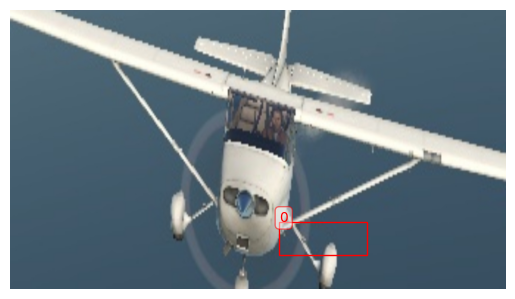

In [172]:
image = '16'
dataset = 'train'
aug_type = 'zoom'

test_image_path = f'datasets/test/images/{dataset}/{image}.jpg'
test_label_path = f'datasets/test/labels/{dataset}/{image}.txt'

aug_image_path = f'datasets/test-aug/images/{aug_type}/{image}.jpg'
aug_label_path = f'datasets/test-aug/labels/{aug_type}/{image}.txt'

aug_image, aug_label = augment_zoom(test_image_path, test_label_path, 2)

save_image(aug_image_path, aug_image)
save_label(aug_label_path, aug_label)

overlay_bbox(aug_image_path, aug_label_path)

# Test Parameters

In [28]:
# parameters for each specfic test














# Training

# Own Implementation of Object Detection System